# Explore data

In [1]:
import pandas as pd
import numpy as np
from icecream import ic
import datetime
import glob

In [8]:
def smooth_5000(compound, nroftweets, small):
    if compound:
        if small:
            print("Compound FWHM = 500")
        else:
            print("Compound FWHM = 5000")
    if nroftweets:
        if small:
            print("Nr FWHM = 500")
        else:
            print("Nr FWHM = 5000")
    return 0

In [16]:
smooth_5000(compound = True, nroftweets = True, small = "False")

Compound FWHM = 500
Nr FWHM = 500


0

In [22]:
data_prefix = "delta"

In [23]:
def set_base_plot_settings(fontsize, if_palette):
    matplotlib.rc('ytick', labelsize=fontsize)
    matplotlib.rc('xtick', labelsize=fontsize)
    themes.theme_minimal(grid=False, ticks=False, fontsize=fontsize)
    a4_dims = (25,15)
    
    if if_palette:
        #          0 black      1 orange  2 L blue   3 green    4 L orange  5 D blue  6 D orange 7 purple
        palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
    else:
        palette = 0
    
    fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
    sns.set(font_scale = 2)

    return fig, ax1, palette

def set_late_plot_settings(if_dates):
    ax1.set(xlabel="", ylabel = "")
    ax1.xaxis.get_label().set_fontsize(40)
    ax1.yaxis.get_label().set_fontsize(40)

    ax1.grid(color='darkgrey', linestyle='-', linewidth=0.5, which= "both")
    if if_dates:
        # Define the date format
        ax1.xaxis_date()
        date_form = mdates.DateFormatter("%d-%b")
        ax1.xaxis.set_major_formatter(date_form)

    ax1.set(ylim=(0, None))
    
    #ax1.set_yticklabels(ax1.get_yticks(), size = 35)

    #fig.suptitle("Mentions of 'vaccin*'. 2020 - 2021", size = "40")
    return fig, ax1

def set_late_barplot_settings():
    ax1.set(xlabel="", ylabel = "")
    ax1.xaxis.get_label().set_fontsize(40)
    ax1.yaxis.get_label().set_fontsize(40)
        
    #ax1.set_yticklabels(ax1.get_yticks(), size = 35)

    #fig.suptitle("Mentions of 'vaccin*'. 2020 - 2021", size = "40")
    return fig, ax1

In [24]:
filename = "../" + data_prefix + "_final.csv"
df = pd.read_csv(filename)
df = df.sort_values("created_at")
df.head()

,index,created_at,id,text,search_keyword,date,mentioneless_text,text50,dupe50,nr_of_tweets,...,normalized_entropy,centered_entropy,s200_compound,s200_nr_of_tweets,s500_compound,s500_nr_of_tweets,date_ordinal,hashtags,tokens_list,tokens_string
0,20015,2021-01-02 00:31:24,1345165764114919424,@rasmuskongshoej @HansenKenn Margrethe har alt...,['delta'],2021-01-02,Margrethe har altid opfattet sin rolle som p...,Margrethe har altid opfattet sin rolle som p...,False,47,...,0.244961,-0.278567,0.017028,48.891222,0.019870,64.241244,737792,[],"['margrethe', 'opfatte', 'rolle', 'præcis', 'm...",margrethe opfatte rolle præcis modsætte deltag...
1,20016,2021-01-02 03:17:48,1345207638829764609,@headacheofsmurf @stinelinnemann @VivaDenmark ...,['delta'],2021-01-02,"Set får mig til at tænke over, hvordan og h...","Set får mig til at tænke over, hvordan og h...",False,47,...,0.244961,-0.278567,0.017583,48.939109,0.019828,64.288612,737792,[],"['tænke', 'lange', 'tid', 'gæst', 'mulighed', ...",tænke lange tid gæst mulighed fysisk deltagelse
2,20017,2021-01-02 05:10:26,1345235985056067586,"@MagnusBarsoe Gang på gang, ærgres jeg over ik...",['delta'],2021-01-02,"Gang på gang, ærgres jeg over ikke at kunne l...","Gang på gang, ærgres jeg over ikke at kunne l...",False,47,...,0.244961,-0.278567,0.018137,48.987624,0.019784,64.336066,737792,[],"['gang', 'gang', 'ærgre', 'læse', 'artikel', '...",gang gang ærgre læse artikel brik forstå helhe...
3,20018,2021-01-02 08:23:12,1345284495780491264,@Riis81417347 Du er en oplagt deltager til tv2...,['delta'],2021-01-02,Du er en oplagt deltager til tv2 's presselog...,Du er en oplagt deltager til tv2 's presselog...,False,47,...,0.244961,-0.278567,0.018690,49.036771,0.019741,64.383606,737792,[],"['oplægge', 'deltage', 'tv2', 's', 'presseloge...",oplægge deltage tv2 s presseloge uanset mette ...
4,20019,2021-01-02 08:53:08,1345292029765550086,Hun skal vel holde nytårskur ? Er alle deltag...,['delta'],2021-01-02,Hun skal vel holde nytårskur ? Er alle deltag...,Hun skal vel holde nytårskur ? Er alle deltag...,False,47,...,0.244961,-0.278567,0.019242,49.086556,0.019697,64.431231,737792,['#nedlægkongehuset'],"['vel', 'holde', 'nytårskur', 'deltager', 'pom...",vel holde nytårskur deltager pompøs pjatte vac...


In [25]:
df["date"] = pd.to_datetime(df["created_at"], utc=True).dt.strftime('%Y-%m-%d')
df["date"] = pd.to_datetime(df["date"])

start_date = "2021-01-01" #datetime.date(2021, 1, 1)
mask2021 = (df['date'] >= start_date)
mask2020 = (df['date'] < start_date)
mask2020winter = (df['date'] < "2021-01-01") & (df['date'] >= "2020-11-01")

ic(len(df.loc[mask2021]))
ic(len(df.loc[mask2020winter]))
ic(len(df.loc[mask2020]))

ic| len(df.loc[mask2021]): 13812
ic| len(df.loc[mask2020winter]): 0
ic| len(df.loc[mask2020]): 0


0

In [26]:
df.groupby("search_keyword").count()

,index,created_at,id,text,date,mentioneless_text,text50,dupe50,nr_of_tweets,neg,...,normalized_entropy,centered_entropy,s200_compound,s200_nr_of_tweets,s500_compound,s500_nr_of_tweets,date_ordinal,hashtags,tokens_list,tokens_string
search_keyword,,,,,,,,,,,,,,,,,,,,,
['b.1.617.2'],20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
['b16172'],1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"['delta', 'b.1.617.2']",3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
"['delta', 'b16172']",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"['delta', 'delta variant', 'b16172']",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"['delta', 'delta variant', 'delta-variant']",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"['delta', 'delta variant', 'indiske variant']",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"['delta', 'delta variant']",52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
"['delta', 'delta-variant', 'b.1.617.2']",3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [27]:
import re

deltas = df[df["search_keyword"] == "['delta']"]
def extract_delta(row):
    delta_list = list(re.findall(r'delta ', row["text"]))
    return delta_list

deltas["delta"] = deltas.apply(lambda row: extract_delta(row), axis = 1)
deltas["delta"] = deltas["delta"].astype(str)

/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [28]:
dls = deltas[deltas["delta"] == "[]"].reset_index(drop = True)
del_ids = dls.id

In [29]:
df = df[~df["id"].isin(del_ids)].reset_index(drop=True)

## Tweet frequency over time

In [30]:
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyplot_themes as themes
import datetime as dt

In [31]:
def get_tweet_frequencies(df):
    # Add freq of hashtags by themselves in the dataset
    tweet_freq = pd.DataFrame({'nr_of_tweets' : df.groupby(['date']).size()}).reset_index()

    # Add the whole_frew to id_hashtag
    freq_tweets = pd.merge(df, tweet_freq, how='left', on=['date'])#, 'id', 'created_at'])
    
    return freq_tweets

In [32]:
df = get_tweet_frequencies(df.drop("nr_of_tweets", axis=1))

In [33]:
df.nr_of_tweets.describe()

count    442.000000
mean      13.153846
std       12.117671
min        1.000000
25%        3.000000
50%       10.000000
75%       21.000000
max       39.000000
Name: nr_of_tweets, dtype: float64

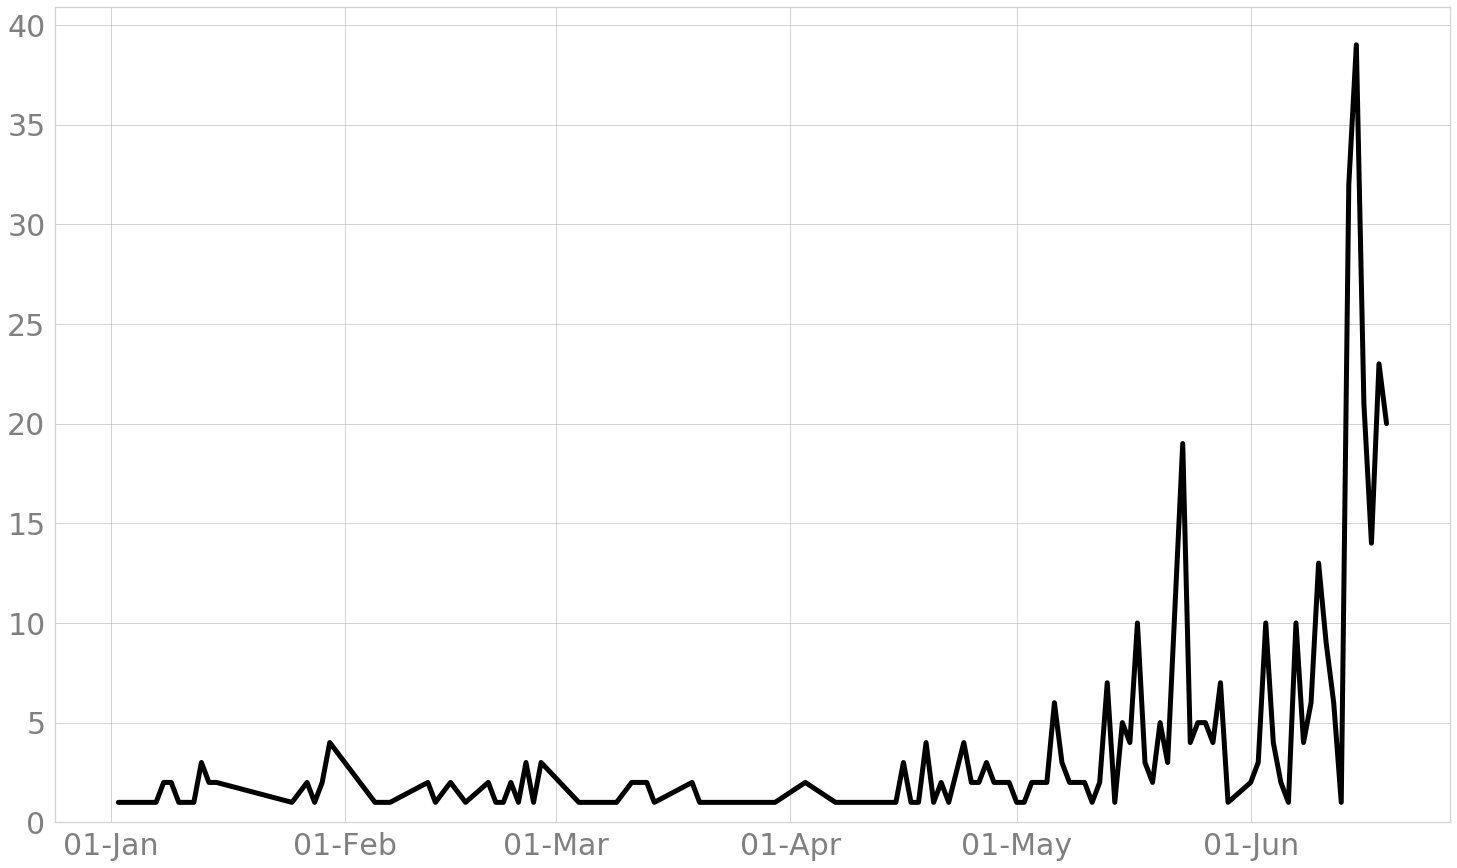

In [36]:
fig, ax1, palette = set_base_plot_settings(fontsize=30, if_palette = True)

ax1 = sns.lineplot(x="date", y="nr_of_tweets", 
                  color = palette[0], 
                   #alpha = 0.30,
                     linewidth = 5, data = df)

#ax1 = sns.lineplot(x="date", y="s500_nr_of_tweets", 
#                  color = palette[5], 
#                     linewidth = 5, data = df)

fig, ax1 = set_late_plot_settings(if_dates = True)

#plot_name = "fig/all_vaccin_mentions.png"
#fig.savefig(plot_name)

fig.show()

# Hashtags

In [37]:
import re

def extract_hashtags(row):
    unique_hashtag_list = list(re.findall(r'#\S*\w', row["text"]))
    return unique_hashtag_list

def hashtag_per_row(data):
    # Create hashtags column with the actual unique hashtags
    data["hashtags"] = data.apply(lambda row: extract_hashtags(row), axis = 1)

    # Let's take a subset of necessary columns, add id
    df = data[["date", "hashtags"]].reset_index().rename(columns={"index": "id"})

    # Select only the ones where we have more than 1 hashtag per tweet
    df = df[df["hashtags"].map(len) > 1].reset_index(drop=True)

    # Hashtag per row
    # convert list of pd.Series then stack it
    df = (df
     .set_index(['date','id'])['hashtags']
     .apply(pd.Series)
     .stack()
     .reset_index()
     .drop('level_2', axis=1)
     .rename(columns={0:'hashtag'}))
    #lowercase!
    df["hashtag"] = df["hashtag"].str.lower()
    df["hashtag"] = df["hashtag"].str.replace("'.", "")
    df["hashtag"] = df["hashtag"].str.replace("’.", "")

    return df

hashtags = hashtag_per_row(df)

In [38]:
# Aggregate a frequency DF
def get_hashtag_frequencies(df):
    # Add freq of hashtags by themselves in the dataset
    tweet_freq = pd.DataFrame({'nr_of_hashtags' : df.groupby(['hashtag']).size()}).reset_index()
    return tweet_freq

In [39]:
freq_hashtags = get_hashtag_frequencies(hashtags)
df1 = freq_hashtags.sort_values(by=['nr_of_hashtags'], ascending=False)

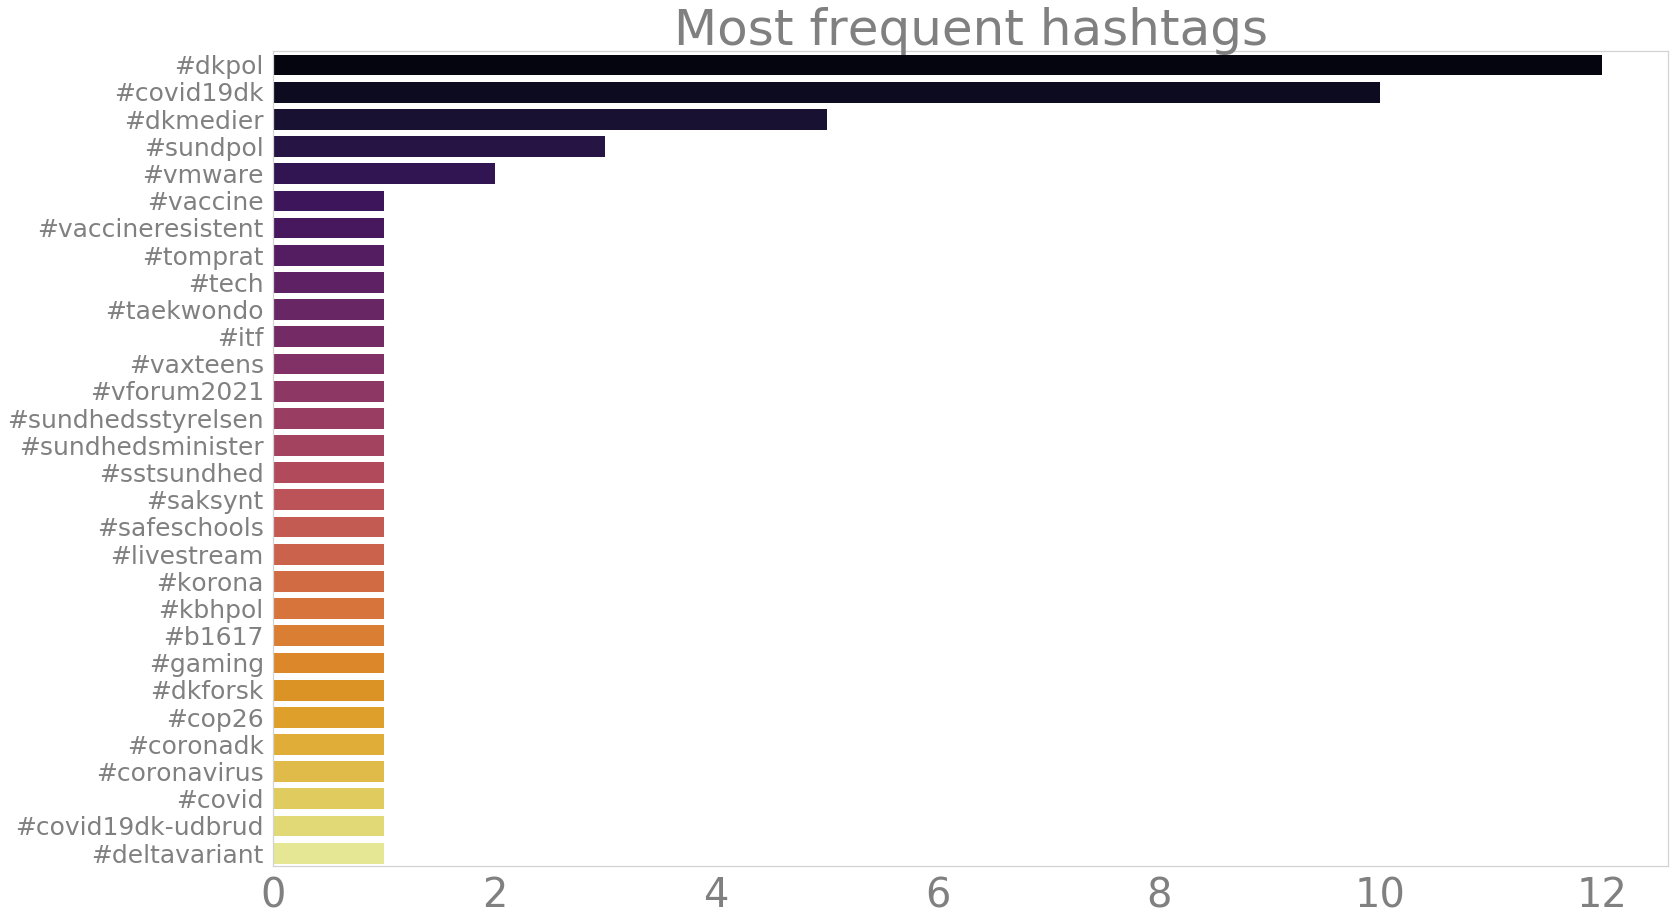

In [40]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes

matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)

df0 = df1.nlargest(30, columns=['nr_of_hashtags'])
nr_hash = len(df0["hashtag"].unique())
themes.theme_minimal(grid=False, ticks=False, fontsize=40)

a4_dims = (25,15) #(11.7, 8.27)
fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

palette = sns.color_palette("inferno", nr_hash)

ax = sns.barplot(y="hashtag", x="nr_of_hashtags", palette = palette, data = df0)

ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent hashtags",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

ax.grid(color='white', linestyle='-', linewidth=0.5, which= "both")

plot_name = "fig/frequent_hashtags.png"
#fig.savefig(plot_name, bbox_inches='tight')

## Wordcloud

In [41]:
import spacy
import string
from string import digits
import re
sp = spacy.load('da_core_news_lg')

file = open("../hope-keyword-templates/src/stop_words.txt","r+")
stop_words = file.read().split()

# Lemmatize stop words
stops = " ".join(stop_words)
stops = sp(stops)
my_stop_words = [t.lemma_ for t in stops]

FileNotFoundError: [Errno 2] No such file or directory: '../hope-keyword-templates/src/stop_words.txt'

In [22]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def lemmas(row):
    tweet = row["mentioneless_text"].lower()
    tweet = remove_emoji(tweet)
    tweet = re.sub(r'@(\S*)\w', '', tweet) #mentions
    tweet = re.sub(r'#\S*\w', '', tweet) # hashtags
    # Remove URLs
    url_pattern = re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')
    tweet = re.sub(url_pattern, '', tweet)
    
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    #tweet = tweet.translate(str.maketrans('', '', digits))
    tweet = tweet.replace('”', '')
    tweet = tweet.replace('“', '')
    
    sentence = sp(tweet)
    lemmas = []
    for word in sentence:
        lemmas.append(word.lemma_)
    res = [x for x in lemmas if x not in my_stop_words]
    hmm = ['   ','  ',' ','','♂','','❤','','🤷']
    res = [x for x in res if x not in hmm]
    return res

#freq_df["tokens_list"] = freq_df.apply(lambda row: lemmas(row), axis = 1)

In [45]:
def join_tokens(row):
    res = " ".join(row["tokens_list"])
    return res

#freq_df["tokens_string"] = freq_df.apply(lambda row: join_tokens(row), axis = 1)
texts = df["tokens_string"]

In [46]:
word_freq = df.tokens_string.str.split(expand=True).stack().value_counts()

In [47]:
word_freq = word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})

In [48]:
import string

texts = ", ".join(texts)
texts = texts.translate(str.maketrans('', '', string.punctuation))
texts = texts.lower()

FileNotFoundError: [Errno 2] No such file or directory: 'fig/word_frequency.png'

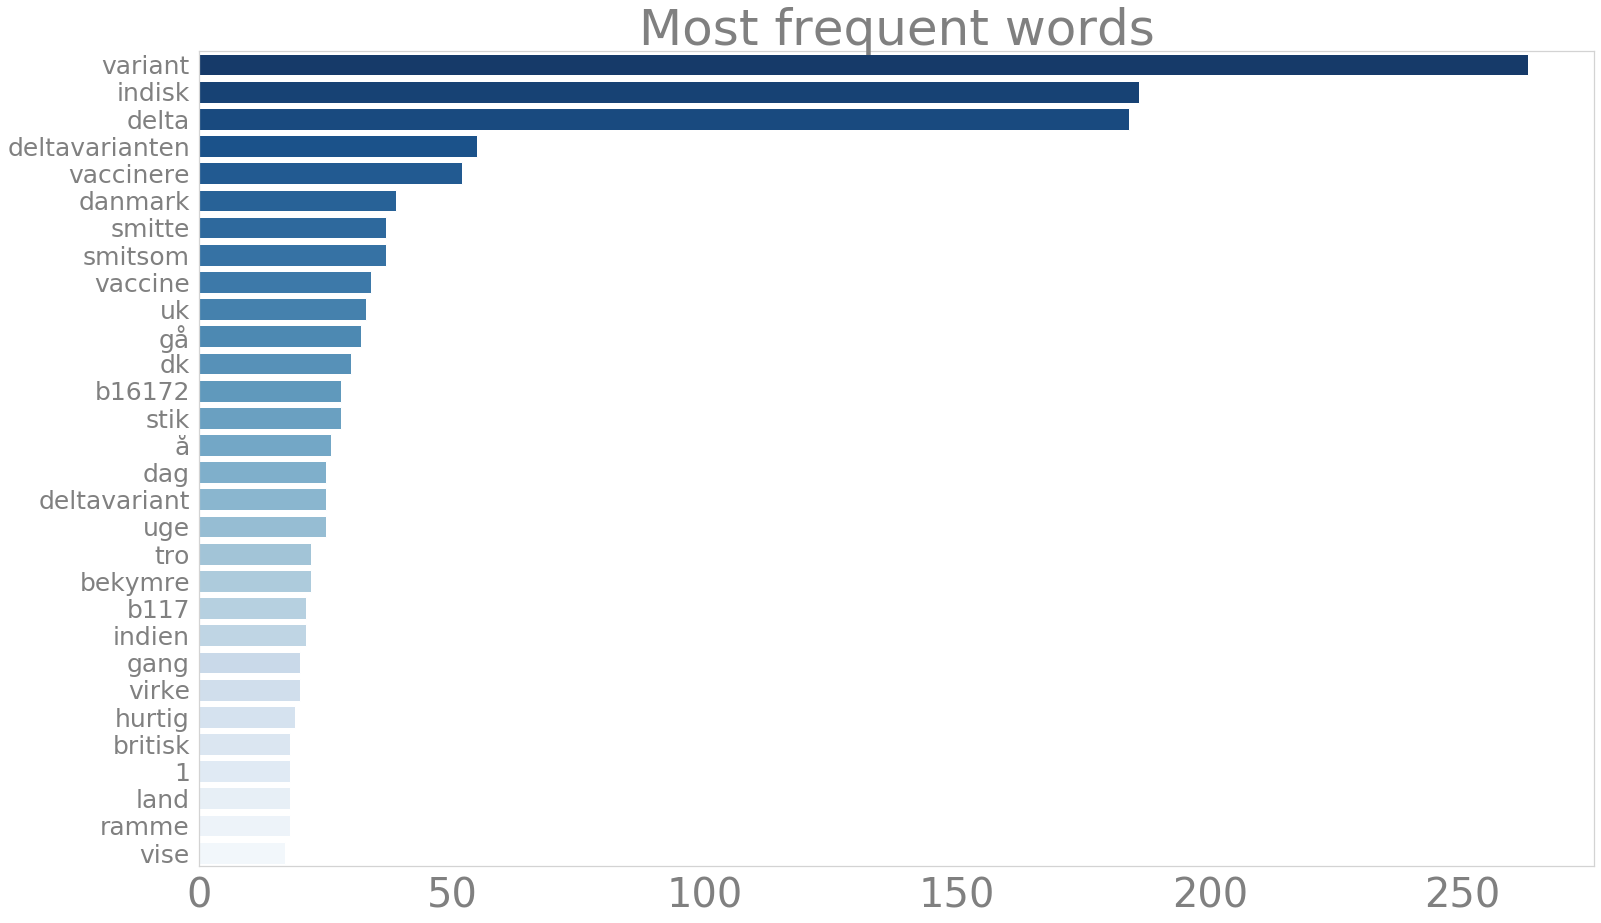

In [50]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes

#word_freq = word_freq[~word_freq["word"].isin(stop_words)]
df0 = word_freq.nlargest(30, columns=['Frequency'])
nr_hash = len(df0["word"].unique())

matplotlib.rc('ytick', labelsize=30)
matplotlib.rc('xtick', labelsize=30)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
palette = sns.color_palette("Blues_r", nr_hash)

ax = sns.barplot(y="word", x="Frequency", palette = palette, data = df0)

ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent words",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

plot_name = "fig/word_frequency.png"
fig.savefig(plot_name)

## For neg and pos datasets

In [24]:
neg["tokens_list"] = neg.apply(lambda row: lemmas(row), axis = 1)
neg["tokens_string"] = neg.apply(lambda row: join_tokens(row), axis = 1)
neg_word_freq = neg.tokens_string.str.split(expand=True).stack().value_counts()
neg_word_freq = neg_word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})

pos["tokens_list"] = pos.apply(lambda row: lemmas(row), axis = 1)
pos["tokens_string"] = pos.apply(lambda row: join_tokens(row), axis = 1)
pos_word_freq = pos.tokens_string.str.split(expand=True).stack().value_counts()
pos_word_freq = pos_word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})

/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



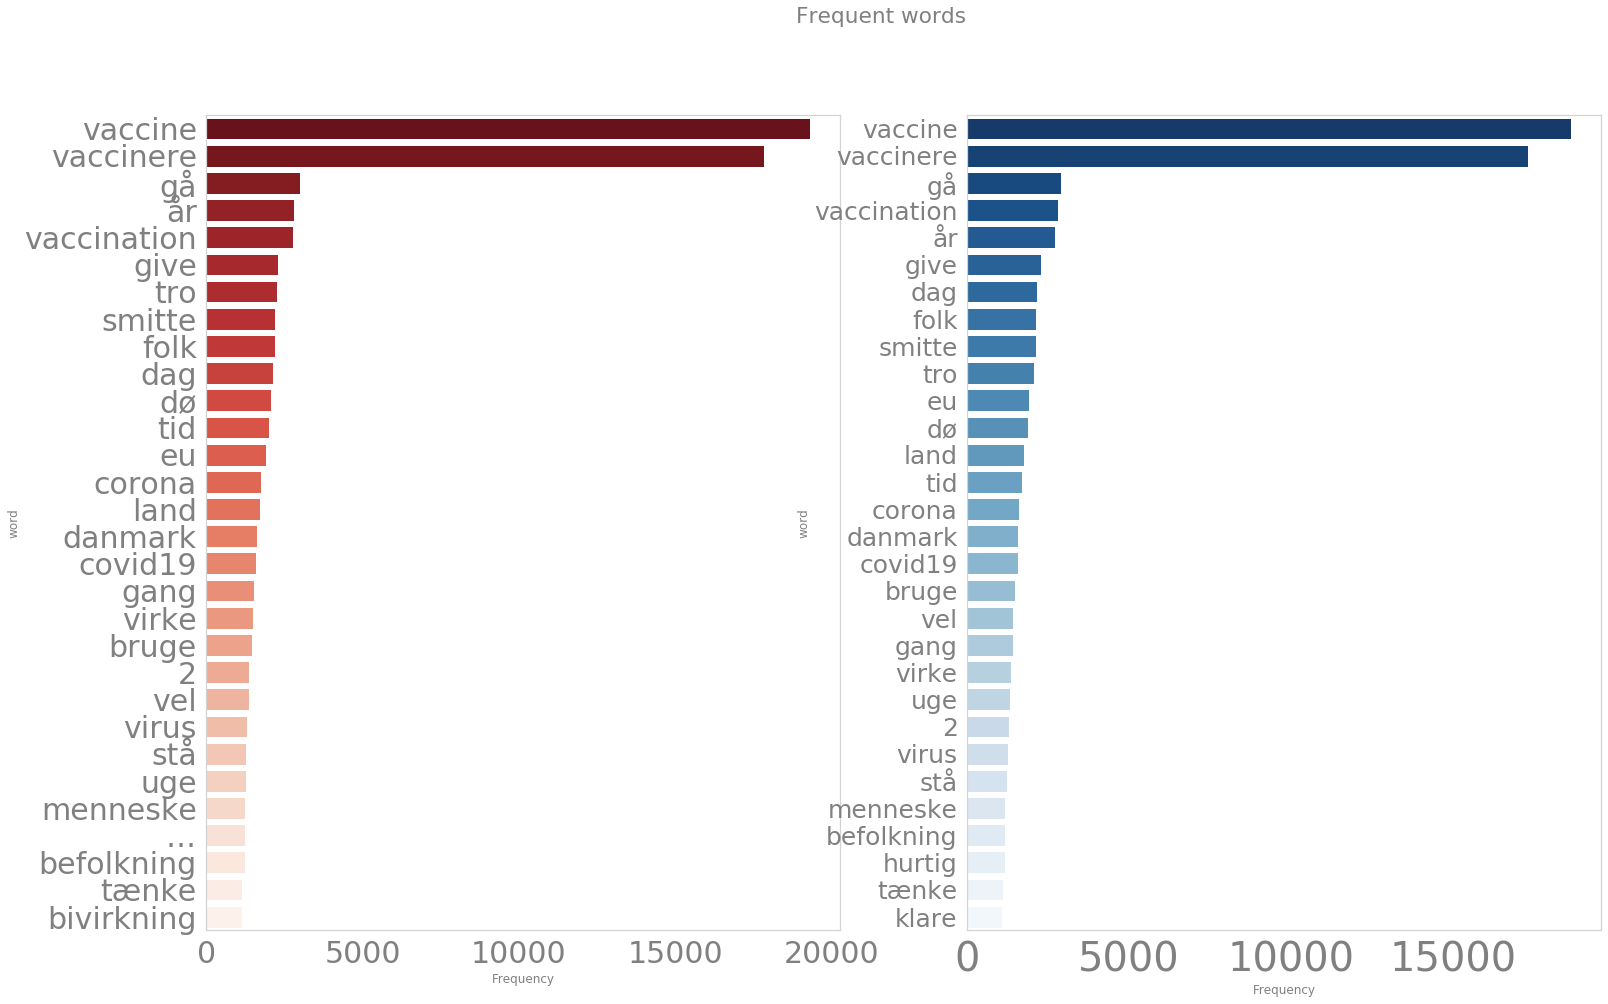

In [25]:
word_freq = neg_word_freq[~neg_word_freq["word"].isin(stop_words)]
df0 = word_freq.nlargest(30, columns=['Frequency'])

word_freq = pos_word_freq[~pos_word_freq["word"].isin(stop_words)]
df00 = word_freq.nlargest(30, columns=['Frequency'])

matplotlib.rc('ytick', labelsize=30)
matplotlib.rc('xtick', labelsize=30)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=a4_dims)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)

ax1 = sns.barplot(y="word", x="Frequency", palette="Reds_r", data = df0, ax=ax1)
ax2 = sns.barplot(y="word", x="Frequency", palette = "Blues_r", data = df00, ax=ax2)

ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent words",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

fig.suptitle("Frequent words")


ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

plot_name = "fig/pos_neg_word_frequency.png"
fig.savefig(plot_name, bbox_inches='tight')

In [26]:
one = list(df0["word"])
two = list(df00["word"])

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

print(intersection(one, two))

['covid19', 'tro', 'gå', 'stå', 'virke', 'folk', 'gang', 'år', 'bruge', 'land', 'danmark', 'vaccination', '2', 'virus', 'dø', 'vaccine', 'befolkning', 'menneske', 'smitte', 'give', 'corona', 'uge', 'eu', 'tid', 'vel', 'tænke', 'dag', 'vaccinere']


In [27]:
# Unique words
list(set(one).symmetric_difference(set(two)))

['klare', 'hurtig', 'bivirkning', '…']

## Word cloud

In [33]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    plot_name = "fig/word_cloud.png"
    plt.savefig(plot_name)

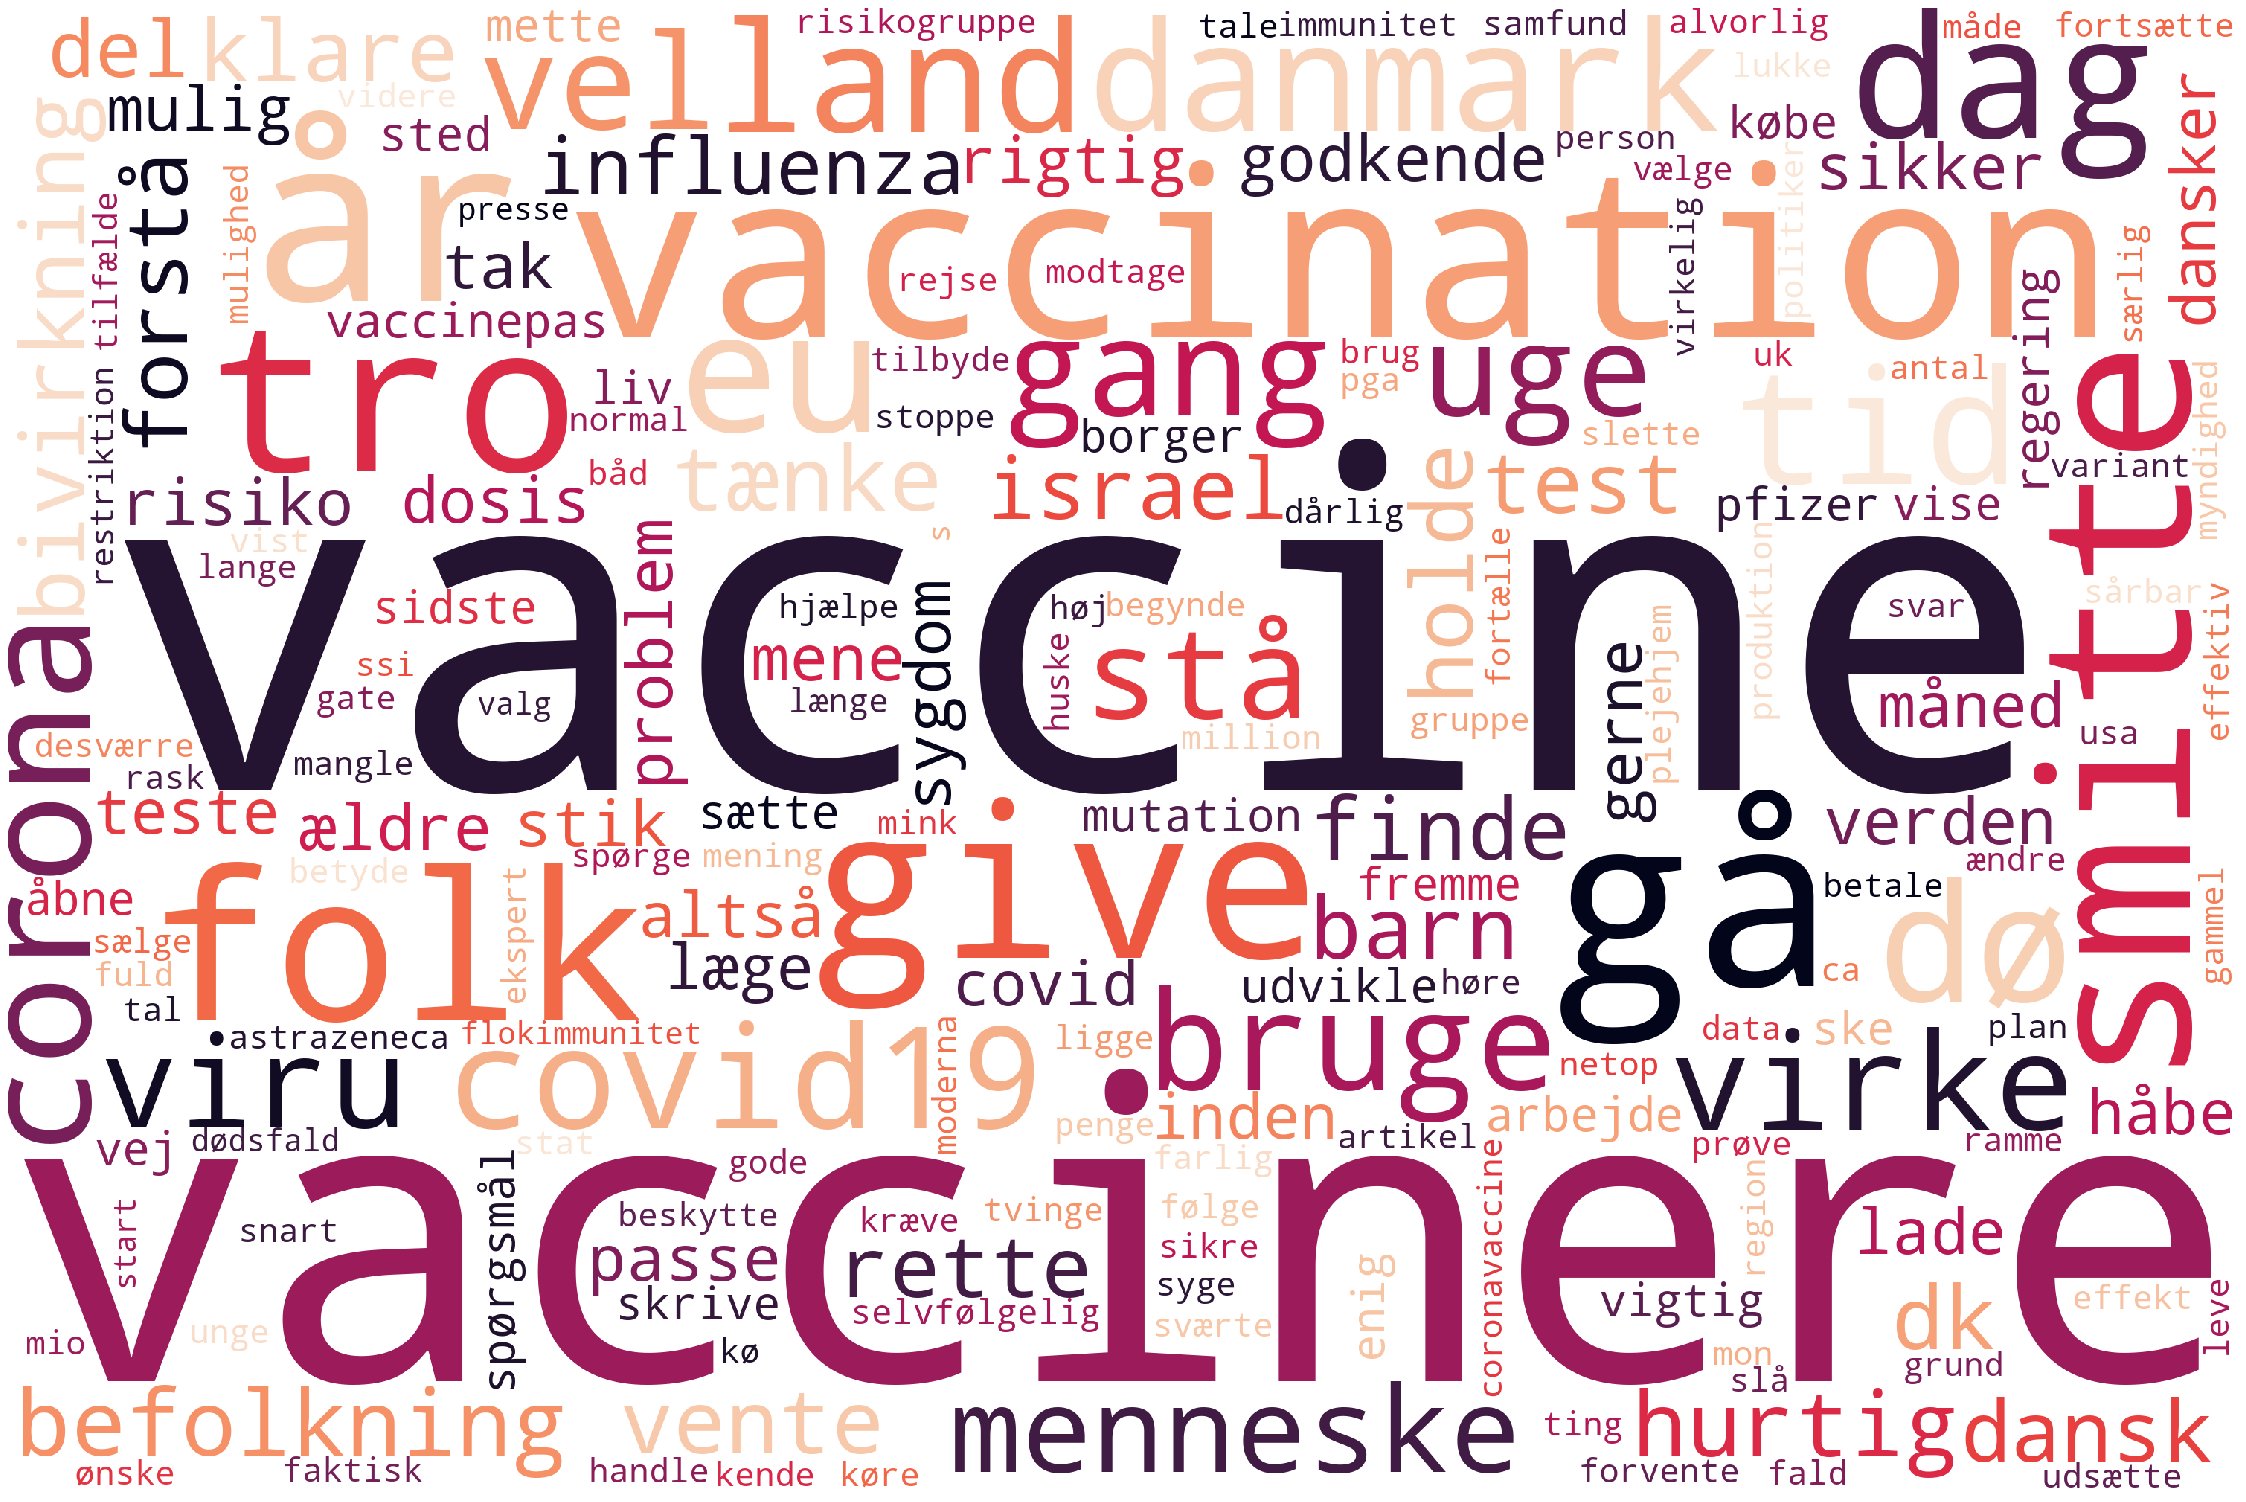

In [34]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='white', colormap="rocket", 
                      collocations=False, stopwords = stop_words).generate(texts)
# Plot
plot_cloud(wordcloud)

In [51]:
from nltk import bigrams
import itertools
import collections
import networkx as nx
import spacy
import nltk

In [52]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

#nlp = spacy.load("da_core_news_sm")

%matplotlib inline

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 0 to 441
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               442 non-null    int64         
 1   created_at          442 non-null    object        
 2   id                  442 non-null    int64         
 3   text                442 non-null    object        
 4   search_keyword      442 non-null    object        
 5   date                442 non-null    datetime64[ns]
 6   mentioneless_text   442 non-null    object        
 7   text50              442 non-null    object        
 8   dupe50              442 non-null    bool          
 9   neg                 442 non-null    float64       
 10  neu                 442 non-null    float64       
 11  pos                 442 non-null    float64       
 12  compound            442 non-null    float64       
 13  centered_compound   442 non-null    float64       

In [55]:
# Create list of lists containing bigrams in tweets
#terms_bigram = list(bigrams(wordlist))
terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_list']]
#terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_no_stop']]

# View bigrams for the first tweet
terms_bigram[0]

[('[', "'"),
 ("'", 'n'),
 ('n', 'e'),
 ('e', 'i'),
 ('i', "'"),
 ("'", ','),
 (',', ' '),
 (' ', "'"),
 ("'", 'f'),
 ('f', 'o'),
 ('o', 'r'),
 ('r', 'v'),
 ('v', 'e'),
 ('e', 'n'),
 ('n', 't'),
 ('t', 'e'),
 ('e', "'"),
 ("'", ','),
 (',', ' '),
 (' ', "'"),
 ("'", 'd'),
 ('d', 'e'),
 ('e', 'l'),
 ('l', 't'),
 ('t', 'a'),
 ('a', "'"),
 ("'", ','),
 (',', ' '),
 (' ', "'"),
 ("'", 'i'),
 ('i', 'd'),
 ('d', 'i'),
 ('i', 'o'),
 ('o', 't'),
 ('t', 'i'),
 ('i', "'"),
 ("'", ','),
 (',', ' '),
 (' ', "'"),
 ("'", 'm'),
 ('m', 'e'),
 ('e', 'n'),
 ('n', 'e'),
 ('e', "'"),
 ("'", ','),
 (',', ' '),
 (' ', "'"),
 ("'", 'd'),
 ('d', 'a'),
 ('a', 'm'),
 ('m', 'e'),
 ('e', 'n'),
 ('n', 'e'),
 ('e', "'"),
 ("'", ','),
 (',', ' '),
 (' ', "'"),
 ("'", 'd'),
 ('d', 'a'),
 ('a', 'm'),
 ('m', 'e'),
 ('e', 'n'),
 ('n', 'e'),
 ('e', "'"),
 ("'", ']')]

In [39]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

In [40]:
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=["bigram", "count"])

bigram_df

,bigram,count
0,"(vaccine, virke)",873
1,"(lade, vaccinere)",676
2,"(give, mening)",609
3,"(covid19, vaccine)",563
4,"(bill, gate)",553
5,"(mette, frederiksen)",429
6,"(dø, vaccine)",428
7,"(udvikle, vaccine)",427
8,"(lange, tid)",419
9,"(’, s)",414


In [44]:
bigram_df = bigram_df.drop([9, 27, 28, 29]).reset_index(drop=True)

In [45]:
bigram_df.head(10)

,bigram,count
0,"(vaccine, virke)",873
1,"(lade, vaccinere)",676
2,"(give, mening)",609
3,"(covid19, vaccine)",563
4,"(bill, gate)",553
5,"(mette, frederiksen)",429
6,"(dø, vaccine)",428
7,"(udvikle, vaccine)",427
8,"(lange, tid)",419
9,"(tilbyde, vaccine)",410


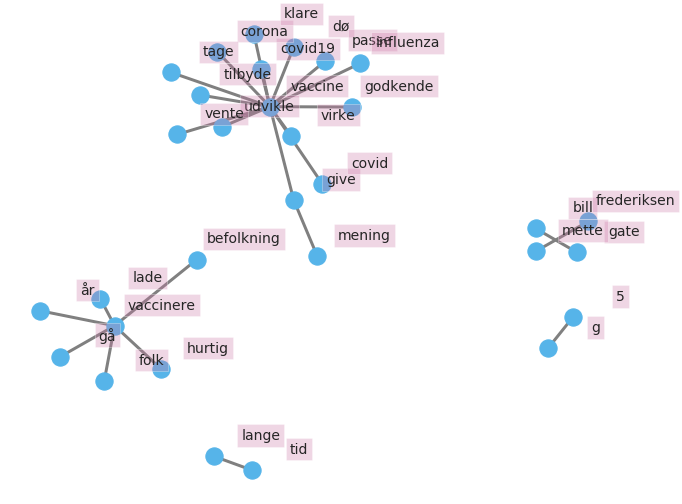

In [46]:
palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Create dictionary of bigrams and their counts
d = bigram_df.set_index("bigram").T.to_dict("records")
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))

fig, ax = plt.subplots(figsize=(11, 9))

pos = nx.spring_layout(G, k=5)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=3,
                 edge_color= "grey",#palette[0], #'red',
                 node_color= palette[2], #'green',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.065
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor= palette[7], #'red', 
                      alpha=0.3), ## 0.5),
            horizontalalignment='center', fontsize=14)
    

fig.patch.set_visible(False)
ax.axis('off')

plt.savefig("fig/bigram_graph.png", dpi=150)

plt.show()

## Ngrams with emojis? :) 

In [66]:
def extract_emoji(string):
    string = string["text"]
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    res = re.findall(emoji_pattern, string)
    #res = " ".join(res)
    return res

In [67]:
freq_df["emojis_list"] = freq_df.apply(lambda row: extract_emoji(row), axis = 1)

In [68]:
freq_df.iloc[11535].emojis_list

[]

In [69]:
emojis = freq_df[freq_df["emojis_list"] != []]

ValueError: ('Lengths must match to compare', (44786,), (0,))

In [65]:
# Create list of lists containing bigrams in tweets
#terms_bigram = list(bigrams(wordlist))
terms_bigram = [list(bigrams(tweet)) for tweet in freq_df['emojis_list']]
#terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_no_stop']]

# View bigrams for the first tweet
terms_bigram[0]

NameError: name 'bigrams' is not defined